In [2]:
# schiller test --> iodine that stains different on abnormal cells on cervix
# hinsellman --> coloscopy using scope on cervix
# cytology --> pap smear
# biopsy --> biopsy 
# These indicate the RESULTS of these tests, assuming they were carried out. 1 means suspect screening, 0 means okay screening. 

# dx columns mean previous cervical diagnosis 
# stds_number is the sum over all std columns
# Cant figure out what stds_n_diagnosis is, though. 

In [122]:
import gc 
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, RocCurveDisplay, PrecisionRecallDisplay, fbeta_score, make_scorer, average_precision_score, log_loss
from sklearn.impute import MissingIndicator, SimpleImputer
import matplotlib.pyplot as plt
import miceforest as mf
from miceforest import mean_match_default
import seaborn as sns
from lightgbm import LGBMClassifier
import inspect 
import warnings
import scipy.stats as stats
from tempfile import mkdtemp
from joblib import Memory
from shutil import rmtree
from mice_imputer import *
from missing_transformer import *
import pickle 
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


In [4]:
df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00383/risk_factors_cervical_cancer.csv")

# Encode missings

In [5]:
df = df.replace({"?": pd.NA})

# Rename columns to be more manageable

In [6]:
df.columns.values

array(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)',
       'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs',
       'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis',
       'STDs: Time since last diagnosis', 'Dx:Cancer', 'Dx:CIN', 'Dx:HPV',
       'Dx', 'Hinselmann', 'Schiller', 'Citology', 'Biopsy'], dtype=object)

In [7]:
new_names = df.columns 
to_rep = {
    "Number" : "n",
    "Contraceptives" : "bc", 
    "Num" : "n",
    "-" : "_",
    "of" : "",
    " " : "_", 
    "(" : "",
    ")" : "",
    "/" : "_",
    ":" : "_", 
    "__" : "_"
}

for key, value in to_rep.items(): 
    new_names = new_names.str.replace(key, value, regex = True)

new_names = new_names.str.lower()

df = df.set_axis(new_names, axis = 1)

df.columns.values

array(['age', 'n_sexual_partners', 'first_sexual_intercourse',
       'n_pregnancies', 'smokes', 'smokes_years', 'smokes_packs_year',
       'hormonal_bc', 'hormonal_bc_years', 'iud', 'iud_years', 'stds',
       'stds_number', 'stds_condylomatosis',
       'stds_cervical_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_aids', 'stds_hiv',
       'stds_hepatitis_b', 'stds_hpv', 'stds_n_diagnosis',
       'stds_time_since_first_diagnosis',
       'stds_time_since_last_diagnosis', 'dx_cancer', 'dx_cin', 'dx_hpv',
       'dx', 'hinselmann', 'schiller', 'citology', 'biopsy'], dtype=object)

In [8]:
df = df.apply(pd.to_numeric, axis = 1).convert_dtypes() # convert_dtypes not working without the apply() call. Probably due to the earlier replace statement, but fiddled for an hour and no dice.

# Data Exploration

## Basic variable description

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
n_sexual_partners,832.0,2.527644,1.66776,1.0,2.0,2.0,3.0,28.0
first_sexual_intercourse,851.0,16.9953,2.803355,10.0,15.0,17.0,18.0,32.0
n_pregnancies,802.0,2.275561,1.447414,0.0,1.0,2.0,3.0,11.0
smokes,845.0,0.145562,0.352876,0.0,0.0,0.0,0.0,1.0
smokes_years,845.0,1.219721,4.089017,0.0,0.0,0.0,0.0,37.0
smokes_packs_year,845.0,0.453144,2.22661,0.0,0.0,0.0,0.0,37.0
hormonal_bc,750.0,0.641333,0.479929,0.0,0.0,1.0,1.0,1.0
hormonal_bc_years,750.0,2.256419,3.764254,0.0,0.0,0.5,3.0,30.0
iud,741.0,0.112011,0.315593,0.0,0.0,0.0,0.0,1.0


In [10]:
df.sum(axis = 0)

age                                   23012.000000
n_sexual_partners                      2103.000000
first_sexual_intercourse              14463.000000
n_pregnancies                          1825.000000
smokes                                  123.000000
smokes_years                           1030.664594
smokes_packs_year                       382.906638
hormonal_bc                             481.000000
hormonal_bc_years                      1692.314401
iud                                      83.000000
iud_years                               381.470000
stds                                     79.000000
stds_number                             133.000000
stds_condylomatosis                      44.000000
stds_cervical_condylomatosis              0.000000
stds_vaginal_condylomatosis               4.000000
stds_vulvo_perineal_condylomatosis       43.000000
stds_syphilis                            18.000000
stds_pelvic_inflammatory_disease          1.000000
stds_genital_herpes            

## Iud/smoking/HBC years are always >0 if you have IUD/smoke/HBC.

In [11]:
def check_zerotrunc(df, bin_col, yr_col):
    return np.any((df[bin_col] == 1) & (df[yr_col] == 0))

In [12]:
bin_cols = ["iud", "smokes", "hormonal_bc"]
yr_cols = ["iud_years", "smokes_years", "hormonal_bc_years"]

for bin, yr in zip(bin_cols, yr_cols):
    print(f"{bin} == 1 when {yr} == 0?", check_zerotrunc(df, bin, yr))

iud == 1 when iud_years == 0? False
smokes == 1 when smokes_years == 0? False
hormonal_bc == 1 when hormonal_bc_years == 0? False


## Years variables are not strictly integers

In [54]:
df_mod = df % 1 == 0
df_mod.all(axis = 0)

age                          True
n_sexual_partners            True
first_sexual_intercourse     True
n_pregnancies                True
smokes                       True
smokes_years                False
smokes_packs_year           False
hormonal_bc                  True
hormonal_bc_years           False
iud                          True
iud_years                   False
stds_number                  True
hinselmann                   True
schiller                     True
citology                     True
biopsy                       True
stds_condy                  False
stds_other                  False
dx_any                       True
dtype: bool

## Verify that the count of stds is linear combination of all std columns. 

In [55]:
all((df[df.columns[df.columns.str.startswith("stds_")]].drop(["stds_time_since_first_diagnosis", "stds_time_since_last_diagnosis", "stds_n_diagnosis", "stds_number"], axis = 1).sum(axis = 1) == df.stds_number).dropna())

KeyError: "['stds_time_since_first_diagnosis', 'stds_time_since_last_diagnosis', 'stds_n_diagnosis'] not found in axis"

## Verify that boolean `stds` column is always 1 if count `stds_number` column is non-zero

In [ ]:
any((df.stds.dropna() == 0) & (df.stds_number.dropna() > 0))

False

## Drop time since std diagnoses

In [ ]:
df.drop(df.columns.values[df.columns.str.startswith("stds_time")], axis = 1, inplace = True)

## Check for/drop constant/near-constant columns

In [ ]:
const = df.nunique() == 1
if any(const):
    print("Deleting constant columns: {}".format(df.columns.values[const]))
    df.drop(df.columns.values[const], axis = 1, inplace = True)

# near_const = df.sum(axis = 0) <= 18
# if any(near_const): 
#     print(f"\nDeleting near-constant columns: {df.columns.values[near_const]}")
#     df.drop(df.columns.values[near_const], axis = 1, inplace = True)


Deleting constant columns: ['stds_cervical_condylomatosis' 'stds_aids']


## Combine low-proportion columns to avoid issues during cross validation

* Because of the small sample size, dummy variables with low proportions (i.e., "balance") will sometimes end up with all positive (or negative) instances being in the training or test fold, which causes issues. So, I combine some std and previous diagnoses columns to avoid this.

In [ ]:
df.columns[df.columns.str.contains("stds_")]

Index(['stds_number', 'stds_condylomatosis', 'stds_vaginal_condylomatosis',
       'stds_vulvo_perineal_condylomatosis', 'stds_syphilis',
       'stds_pelvic_inflammatory_disease', 'stds_genital_herpes',
       'stds_molluscum_contagiosum', 'stds_hiv', 'stds_hepatitis_b',
       'stds_hpv', 'stds_n_diagnosis'],
      dtype='object')

In [ ]:
condy_mask = df.columns.str.contains("condy")
std_mask = (df.columns.str.startswith("stds_")) & (~df.columns.str.startswith("stds_n"))

condy = df.columns[condy_mask]
stds = df.columns[std_mask]
not_condy = df.columns[(~condy_mask) & (std_mask)]

In [ ]:
stds_condy = df[condy].max(axis = 1)
stds_other = df[not_condy].max(axis = 1)

In [ ]:
df = df.drop(stds, axis = 1)
df = df.drop("stds", axis = 1)
df["stds_condy"] = stds_condy
df["stds_other"] = stds_other

In [ ]:
dx_mask = df.columns.str.startswith("dx")
dx = df.columns[dx_mask]

dx_any = df[dx].max(axis = 1)

df = df.drop(dx, axis = 1)

df["dx_any"] = dx_any

## Drop n_diagnosis col

In [ ]:
df.drop(["stds_n_diagnosis"], axis = 1, inplace = True)

## Correlations

<Axes: >

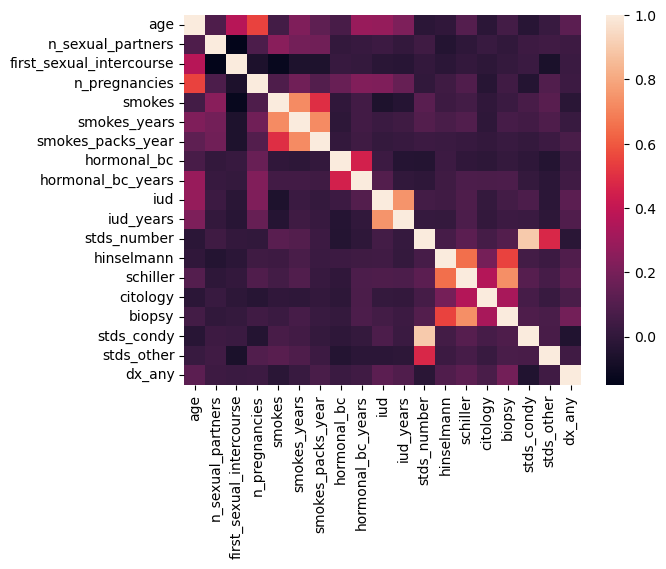

In [ ]:
corr = df.corr()
cols = corr.columns

sns.heatmap(
    corr, 
    xticklabels = cols,
    yticklabels = cols
)

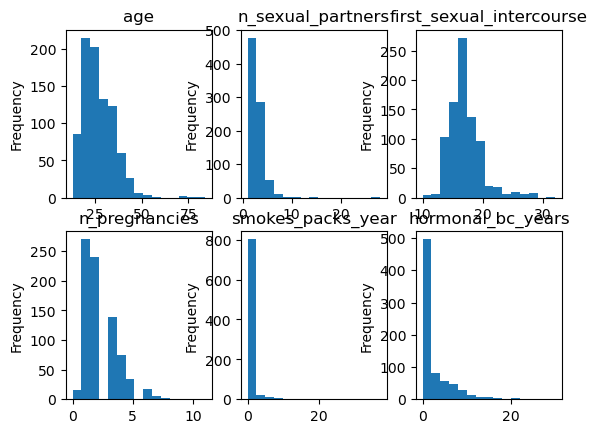

In [ ]:
to_hist = ["age", "n_sexual_partners", "first_sexual_intercourse", "n_pregnancies", "smokes_packs_year", "hormonal_bc_years"]
fig, axs = plt.subplots(nrows = 2, ncols = 3)
plt.rcParams['figure.figsize'] = [15, 7]
for ax, var in zip(axs.ravel(), to_hist): 
    df[var].plot.hist(bins = 15, ax = ax, title = var)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,858.0,26.820513,8.497948,13.0,20.0,25.0,32.0,84.0
n_sexual_partners,832.0,2.527644,1.66776,1.0,2.0,2.0,3.0,28.0
first_sexual_intercourse,851.0,16.9953,2.803355,10.0,15.0,17.0,18.0,32.0
n_pregnancies,802.0,2.275561,1.447414,0.0,1.0,2.0,3.0,11.0
smokes,845.0,0.145562,0.352876,0.0,0.0,0.0,0.0,1.0
smokes_years,845.0,1.219721,4.089017,0.0,0.0,0.0,0.0,37.0
smokes_packs_year,845.0,0.453144,2.22661,0.0,0.0,0.0,0.0,37.0
hormonal_bc,750.0,0.641333,0.479929,0.0,0.0,1.0,1.0,1.0
hormonal_bc_years,750.0,2.256419,3.764254,0.0,0.0,0.5,3.0,30.0
iud,741.0,0.112011,0.315593,0.0,0.0,0.0,0.0,1.0


# Modeling

In [ ]:
x = df.drop(["smokes", "hormonal_bc", "iud", "schiller", "biopsy", "hinselmann"], axis = 1)
x["n_stds"] = x["stds_number"]
x.drop("stds_number", axis = 1, inplace = True)
y = df[["biopsy"]].astype("int64")

## Have to have cat/float/int dtypes for lgbm

In [ ]:
x[x.select_dtypes(include=['Int64', 'Float64']).columns.values] = x.select_dtypes(include=['Int64', 'Float64']).astype('float')
x.dtypes

age                         float64
n_sexual_partners           float64
first_sexual_intercourse    float64
n_pregnancies               float64
smokes_years                float64
smokes_packs_year           float64
hormonal_bc_years           float64
iud_years                   float64
citology                    float64
stds_condy                  float64
stds_other                  float64
dx_any                      float64
n_stds                      float64
dtype: object

## Instantiate base classifier

In [ ]:
clf = LGBMClassifier(objective = "binary", is_unbalance = True)

## Set some useful fixed parameters for each variable

In [ ]:
template = {
    "objective" : "regression"
}

varparms = {}

keys = x.columns.values[x.isna().any()] 

for i in keys: 

    varparms[i] = template.copy()

    if "stds_" in i: 
        varparms[i]["objective"] = "binary"
        varparms[i]["is_unbalance"] = True

    if (x[i].nunique() > 2) & (np.all(x[i].dropna() % 1 == 0)):
        varparms[i]["objective"] = "poisson"

In [ ]:
varparms

{'n_sexual_partners': {'objective': 'poisson'},
 'first_sexual_intercourse': {'objective': 'poisson'},
 'n_pregnancies': {'objective': 'poisson'},
 'smokes_years': {'objective': 'regression'},
 'smokes_packs_year': {'objective': 'regression'},
 'hormonal_bc_years': {'objective': 'regression'},
 'iud_years': {'objective': 'regression'},
 'stds_condy': {'objective': 'binary', 'is_unbalance': True},
 'stds_other': {'objective': 'binary', 'is_unbalance': True},
 'n_stds': {'objective': 'poisson'}}

## Set predictive mean matching scheme for imputer

In [ ]:
mean_match = mean_match_default.copy()
mean_match.set_mean_match_candidates(5)

## Setup pipeline components, instantiate pipe

* Impute missing values, tuning either constant imputation (`simple_union`) or mice imputation (`mice_union`)
* Add a single missingness variable for the sexual history related variables, as this constitutes the bulk of the missingness.
* Scale everything
* Apply PCA to std columns 
* Train/tune LGBM classifier

In [ ]:
simple_union = FeatureUnion(
    transformer_list=[
         ('features', SimpleImputer(strategy='median')),
         ('indicator', missing_transformer())
         ]
)

mice_union = FeatureUnion(
    transformer_list=[
         ('features', mice_imputer(mean_match_scheme = mean_match, mice_iterations = 15, variable_parameters = varparms)),
         ('indicator', missing_transformer())]
)

std_cols = np.where(x.columns.str.startswith("stds"))[0]
print(std_cols)


[ 9 10]


In [ ]:
#cachedir = mkdtemp()
#memory = Memory(location=cachedir, verbose=0)
pipe = Pipeline(
    #memory = memory,
    steps = [
        ("imputer", simple_union),
        ("classifier", clf)
    ]
)

## (Some) Marginal distributions for random search

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

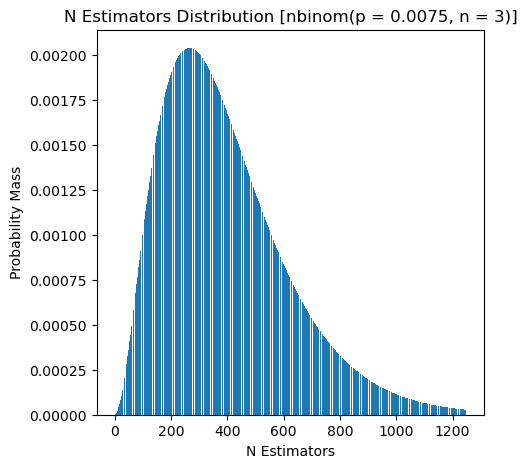

In [ ]:
n = 3
p = .0075
xl = np.floor(np.linspace(0, 1250, 1250))
fig, ax = plt.subplots()

nb = ax.bar(
    xl, 
    stats.nbinom.pmf(xl, n = n, p = p, loc = 1)
)
ax.set_title(f"N Estimators Distribution [nbinom(p = {p}, n = {n})]")
ax.set_ylabel("Probability Mass")
ax.set_xlabel("N Estimators")
plt.show()

In [ ]:
mn = n*(1-p)/p
st = np.sqrt(mn*p**-1)
ps = [.01, .1, .25, .5, .75, .9, .99]
qs = stats.nbinom.ppf(ps, n = n, p = p)
qs = {str(p) : q for p,q in zip(ps, qs)}
qs["mean"] = mn 
qs["std"] = st 
pd.DataFrame(qs, index = ["value"])

,0.01,0.1,0.25,0.5,0.75,0.9,0.99,mean,std
value,56.0,145.0,228.0,354.0,519.0,705.0,1115.0,397.0,230.072452


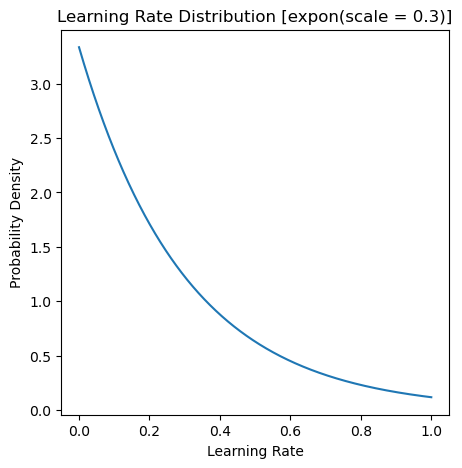

In [ ]:
scale = .3
xl = np.linspace(0, 1, 1000)
fig, ax = plt.subplots()

ex = ax.plot(
    xl, 
    stats.expon.pdf(xl, scale = scale)
)
ax.set_title(f"Learning Rate Distribution [expon(scale = {scale})]")
ax.set_ylabel("Probability Density")
ax.set_xlabel("Learning Rate")
plt.show()

In [ ]:
mn = scale
st = scale
ps = [.01, .1, .25, .5, .75, .9, .99]
qs = stats.expon.ppf(ps, scale = scale)
qs = {str(p) : q for p,q in zip(ps, qs)}
qs["mean"] = mn 
qs["std"] = st 
pd.DataFrame(qs, index = ["value"])

,0.01,0.1,0.25,0.5,0.75,0.9,0.99,mean,std
value,0.003015,0.031608,0.086305,0.207944,0.415888,0.690776,1.381551,0.3,0.3


## Define random search grid

In [ ]:
lr_dist = stats.expon(scale = scale)
ne_dist = stats.nbinom(n = n, p = p, loc = 1)
nl_dist = stats.randint(2, 51)
md_dist = stats.randint(1, 10)
pc_dist = stats.randint(1, 2)
mc_dist = stats.randint(15, 75)

base_grid = {
    "classifier__n_estimators" : ne_dist,
    "classifier__num_leaves" : nl_dist,
    "classifier__max_depth" : md_dist,
    "classifier__learning_rate" : lr_dist,
    "classifier__min_child_samples" : mc_dist
}

grid = [
    {
        "imputer" : [simple_union],
        "imputer__features__strategy" : ["median"],
        **base_grid
    },
    {
        "imputer" : [mice_union],
        "imputer__features__lgb_iterations" : ne_dist,
        "imputer__features__lgb_learning_rate" : lr_dist,
        "imputer__features__lgb_max_depth" : md_dist,
        "imputer__features__lgb_num_leaves" : nl_dist,
        **base_grid
    }
]

## Setup nested CV folds, flush RAM

In [ ]:
inner_cv = StratifiedKFold(n_splits=5, random_state=874841, shuffle = True)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=878571)

In [ ]:
gc.collect()

40

## Fit model, cleanup, and save

In [ ]:
print(x.columns.values)
std_cols

['age' 'n_sexual_partners' 'first_sexual_intercourse' 'n_pregnancies'
 'smokes_years' 'smokes_packs_year' 'hormonal_bc_years' 'iud_years'
 'citology' 'stds_condy' 'stds_other' 'dx_any' 'n_stds']


array([ 9, 10])

In [ ]:
x.shape

(858, 13)

In [ ]:
inner_cv = StratifiedKFold(n_splits=5, random_state=874841, shuffle = True)
outer_cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=878571)

In [ ]:
gc.collect()

0

In [ ]:
print(x.columns.values)
std_cols

['age' 'n_sexual_partners' 'first_sexual_intercourse' 'n_pregnancies'
 'smokes_years' 'smokes_packs_year' 'hormonal_bc_years' 'iud_years'
 'citology' 'stds_condy' 'stds_other' 'dx_any' 'n_stds']


array([ 9, 10])

In [ ]:
f_scorer = make_scorer(fbeta_score, beta = 2)

rcv = RandomizedSearchCV(
    estimator = pipe,
    param_distributions = grid, 
    scoring = f_scorer,
    refit = True, 
    cv = inner_cv,
    return_train_score = True,
    n_jobs = 1,
    n_iter = 500,
    random_state = 97417
)

# res = cross_validate(
#     rcv, 
#     X = x, 
#     y = y.values.flatten(), 
#     cv = outer_cv, 
#     return_estimator = True, 
#     scoring = ["average_precision", "balanced_accuracy", "f1", "precision", "recall"],
#     n_jobs = -1,
#     verbose = 999
# )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................................................................
[CV] START .....................

In [ ]:
x.head()

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,citology,stds_condy,stds_other,dx_any,n_stds
0,18.0,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,34.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,4.0,37.0,37.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0
4,46.0,3.0,21.0,4.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
np.mean(res['test_average_precision'])

0.3140292062667233

In [ ]:
try:
    rmtree(cachedir)
except:
    print("No cache to remove.") 

gc.collect()

No cache to remove.


6954

In [ ]:
def save_obj(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
save_obj(nested_scores, "/home/john/gdrive/github/cervical_cancer/rcv.pkl")

In [ ]:
#best_models = nested_scores['estimator']
# mn = nested_scores["test_score"].mean()
# st = nested_scores["test_score"].std()
# [mn - 1.96*st, mn + 1.96 * st]
#for i, model in enumerate(best_models):
#     #print(model.best_estimator_)
      #print(model.best_params_)
#     print(model.best_score_)

In [ ]:
with open("/home/john/gdrive/github/cervical_cancer/rcv.pkl", "rb") as f:
    res = pickle.load(f)

In [77]:
lens = [len(est.best_params_) for est in res['estimator']]
np.unique(lens)

array([ 7, 10])

In [58]:
best_parms = list(map(lambda x: x.best_params_, res["estimator"]))

In [94]:
best_parms = [est.best_params_ for est in res["estimator"]]
best_inner_scores = [est.best_score_ for est in res["estimator"]]
best_rate = [parms["classifier__learning_rate"] for parms in best_parms]
best_parms_7 = [parms for parms in best_parms if len(parms) == 7]
best_parms_10 = [parms for parms in best_parms if len(parms) == 10]


In [67]:
pd.DataFrame(best_parms_7).T

,0,1,2
classifier__learning_rate,0.006299,0.051701,0.005485
classifier__max_depth,7,1,6
classifier__min_child_samples,21,25,25
classifier__n_estimators,662,477,504
classifier__num_leaves,9,45,36
imputer,"FeatureUnion(transformer_list=[('features', Si...","FeatureUnion(transformer_list=[('features', Si...","FeatureUnion(transformer_list=[('features', Si..."
imputer__features__strategy,median,median,median


In [75]:
pd.DataFrame(best_parms_10).groupby("classifier__learning_rate").size()

classifier__learning_rate
0.010036    1
0.021446    1
0.022343    1
0.068610    3
0.112633    7
0.210302    4
0.328242    1
0.420959    4
dtype: int64

In [88]:
pd.DataFrame(
    [i for i in zip(lens, best_inner_scores, best_rate)], 
    columns = ['n_parms', "f2_score_inner", "classifier_learning_rate"]
)

,n_parms,f2_score_inner,classifier_learning_rate
0,10,0.347386,0.210302
1,10,0.414407,0.112633
2,10,0.345968,0.112633
3,10,0.475631,0.112633
4,10,0.457928,0.420959
5,10,0.373932,0.022343
6,10,0.457751,0.420959
7,10,0.364418,0.010036
8,10,0.462116,0.112633
9,10,0.394758,0.420959


In [97]:
best_final = best_parms[3]
final = pipe.set_params(**best_final)
final.fit(x, y.values.flatten())

Pipeline(steps=[('imputer',
                 FeatureUnion(transformer_list=[('features',
                                                 mice_imputer(lgb_iterations=266,
                                                              lgb_learning_rate=0.13709275624689288,
                                                              lgb_max_depth=6,
                                                              lgb_num_leaves=44,
                                                              mean_match_scheme=<miceforest.MeanMatchScheme.MeanMatchScheme object at 0x7fa6e8257940>,
                                                              mice_iterations=15,
                                                              variable_parameters={1: {'objective': 'poisson'},
                                                                                   2: {'objective': 'poisson'}...
                                                                                   7: {'objective': 'regression'},
                                                                                   9: {'is_unbalance': True,
                                                                                       'objective': 'binary'},
                                                                                   10: {'is_unbalance': True,
                                                                                        'objective': 'binary'},
                                                                                   12: {'objective': 'poisson'}})),
                                                ('indicator',
                                                 missing_transformer())])),
                ('classifier',
                 LGBMClassifier(is_unbalance=True,
                                learning_rate=0.11263311888445775, max_depth=1,
                                min_child_samples=16, n_estimators=399,
                                num_leaves=6, objective='binary'))])

In [112]:
imp = permutation_importance(
    final, 
    x, 
    y.values.flatten(),
    n_repeats = 100,
    random_state = 897447,
    n_jobs=-1
)

In [113]:
imp_sort = imp.importances_mean.argsort()
imp_df = pd.DataFrame(
    imp.importances[imp_sort].T,
    columns = x.columns[imp_sort]
)

Text(0.5, 1.0, 'Permutation Variable Importance')

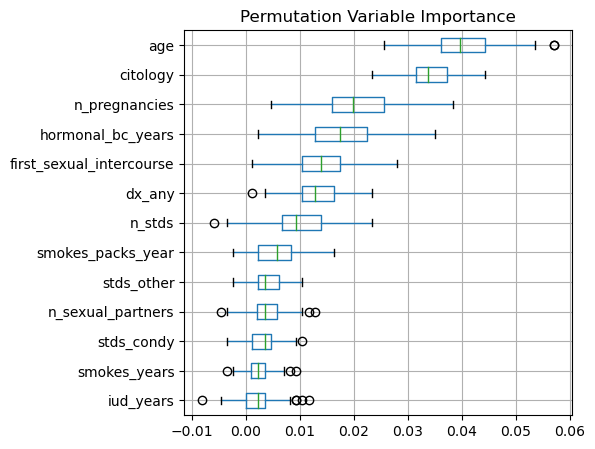

In [121]:
bplot = imp_df.boxplot(vert = False)
bplot.set_title("Permutation Variable Importance")

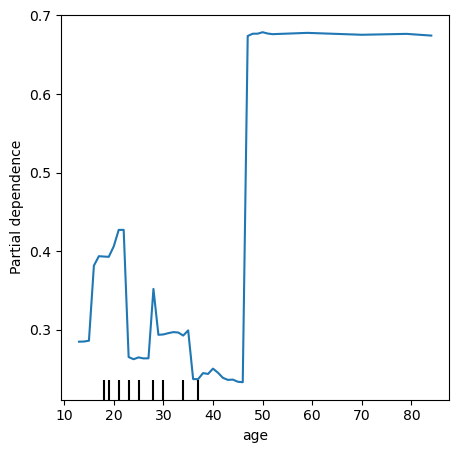

In [136]:
is_cat = x.apply(func = lambda x: x.nunique() == 2) 
PartialDependenceDisplay.from_estimator(final, x, features = ['age'], n_jobs = -1, grid_resolution=1000, percentiles = [0, 1], categorical_features=is_cat)

In [129]:
x

,age,n_sexual_partners,first_sexual_intercourse,n_pregnancies,smokes_years,smokes_packs_year,hormonal_bc_years,iud_years,citology,stds_condy,stds_other,dx_any,n_stds
0,18.0,4.0,15.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1,15.0,1.0,14.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,34.0,1.0,NaN,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,52.0,5.0,16.0,4.0,37.0,37.0,3.00,0.0,0.0,0.0,0.0,1.0,0.0
4,46.0,3.0,21.0,4.0,0.0,0.0,15.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,34.0,3.0,18.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
854,32.0,2.0,19.0,1.0,0.0,0.0,8.00,0.0,0.0,0.0,0.0,0.0,0.0
855,25.0,2.0,17.0,0.0,0.0,0.0,0.08,0.0,1.0,0.0,0.0,0.0,0.0
856,33.0,2.0,24.0,2.0,0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0
